# Нейронный сети

## Поддержка GPU

In [1]:
import numpy as np
import torch


cpu = torch.device("cpu")
gpu = torch.device("cuda:0")

A = np.random.rand(10000, 10000)
B = np.random.rand(10000, 10000)

A_cpu = torch.Tensor(A)
B_cpu = torch.Tensor(B)

A_gpu = A_cpu.to(gpu)
B_gpu = B_cpu.to(gpu)

In [2]:
%%time
C = A @ B

CPU times: user 2min 9s, sys: 16.5 s, total: 2min 25s
Wall time: 4.59 s


In [3]:
%%time
C_cpu = A_cpu @ B_cpu

CPU times: user 35.5 s, sys: 3.57 s, total: 39.1 s
Wall time: 2.35 s


In [4]:
%%time
C_gpu = A_gpu @ B_gpu

CPU times: user 2.51 ms, sys: 0 ns, total: 2.51 ms
Wall time: 2.17 ms


## Граф вычислений

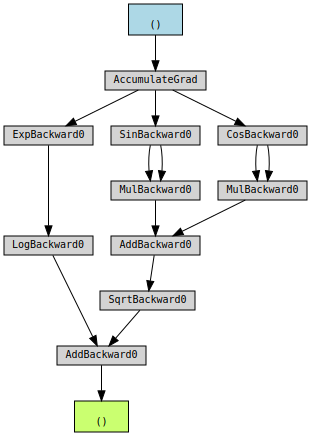

In [5]:
from matplotlib import pyplot as plt
plt.rcParams.update({"font.size": 16})
from torchviz import make_dot

def x_plus_one(x):
    sinx = torch.sin(x)
    cosx = torch.cos(x)
    one = torch.sqrt(sinx*sinx + cosx*cosx)

    expx = torch.exp(x)
    x = torch.log(expx)
    return x + one

x = torch.tensor(0., requires_grad=True)
y = x_plus_one(x)

make_dot(y)

Text(0, 0.5, '$y$')

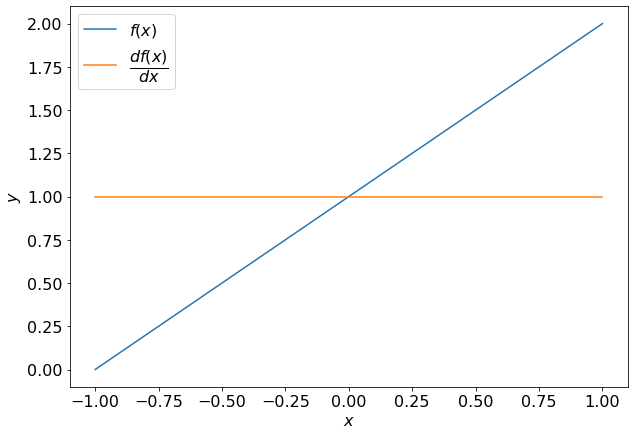

In [6]:
X = np.linspace(-1, 1, 100)

def compute_derivative(f, x):
    x = torch.tensor(x, requires_grad=True)
    y = f(x)
    y.backward()
    return y.item(), x.grad.item()

dfdx = [compute_derivative(x_plus_one, x) for x in X]

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(X, dfdx)
ax.legend(["$f(x)$", r"$\dfrac{d f(x)}{dx}$"])
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

## Оптимизация

In [7]:
def rosen(x, y):
    return (1 - x)**2 + 100*(y - x**2)**2



# initial value
x = torch.tensor(0., requires_grad=True)
y = torch.tensor(3., requires_grad=True)

# optimizer
optimizer = torch.optim.AdamW([x, y], lr=0.1)
trace = {"x": [], "y": [], "z": []}


# optimizing loop
for i in range(100):
    # compute value
    z = rosen(x, y)
    
    # store for later
    trace["x"].append(x.item())
    trace["y"].append(y.item())
    trace["z"].append(z.item())
    
    # gradient descent step
    optimizer.zero_grad()
    z.backward()
    optimizer.step()
    

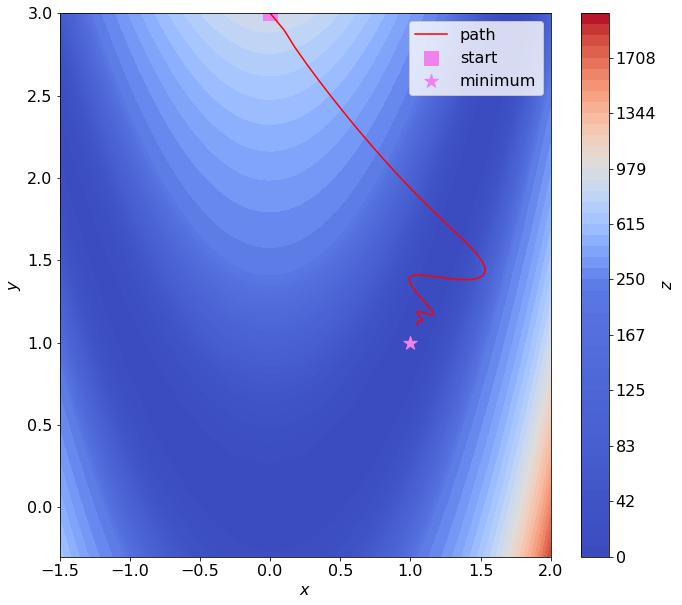

In [8]:
n_points = 100

# surface
xh = np.linspace(-1.5, 2.0, n_points)
yh = np.linspace(-0.3, 3, n_points)
xv, yv = np.meshgrid(xh, yh)
zv = rosen(xv.reshape(-1), yv.reshape(-1)).reshape(n_points, n_points)
surface = {"x": xv, "y": yv, "z": zv}


levels = np.hstack([np.linspace(0, 200, 25), np.linspace(250, 2000, 25)])
fig, ax = plt.subplots(figsize=(11, 10))
cf = ax.contourf(surface["x"], surface["y"], surface["z"], levels=levels, cmap="coolwarm")
ax.plot(trace["x"], trace["y"], "r", label="path")
ax.scatter(trace["x"][0], trace["y"][0], marker="s", s=200, color="violet", label="start")
ax.scatter([1], [1], marker="*", s=200, color="violet", label="minimum")
cbar = fig.colorbar(cf)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
cbar.set_label("$z$")
ax.legend()

In [9]:
def show_image(ax, image, title=None, cmap=None):
    """
    Вывести изображение в указанных осях.
    """
    ax.imshow(image, cmap=cmap)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)


## MNIST

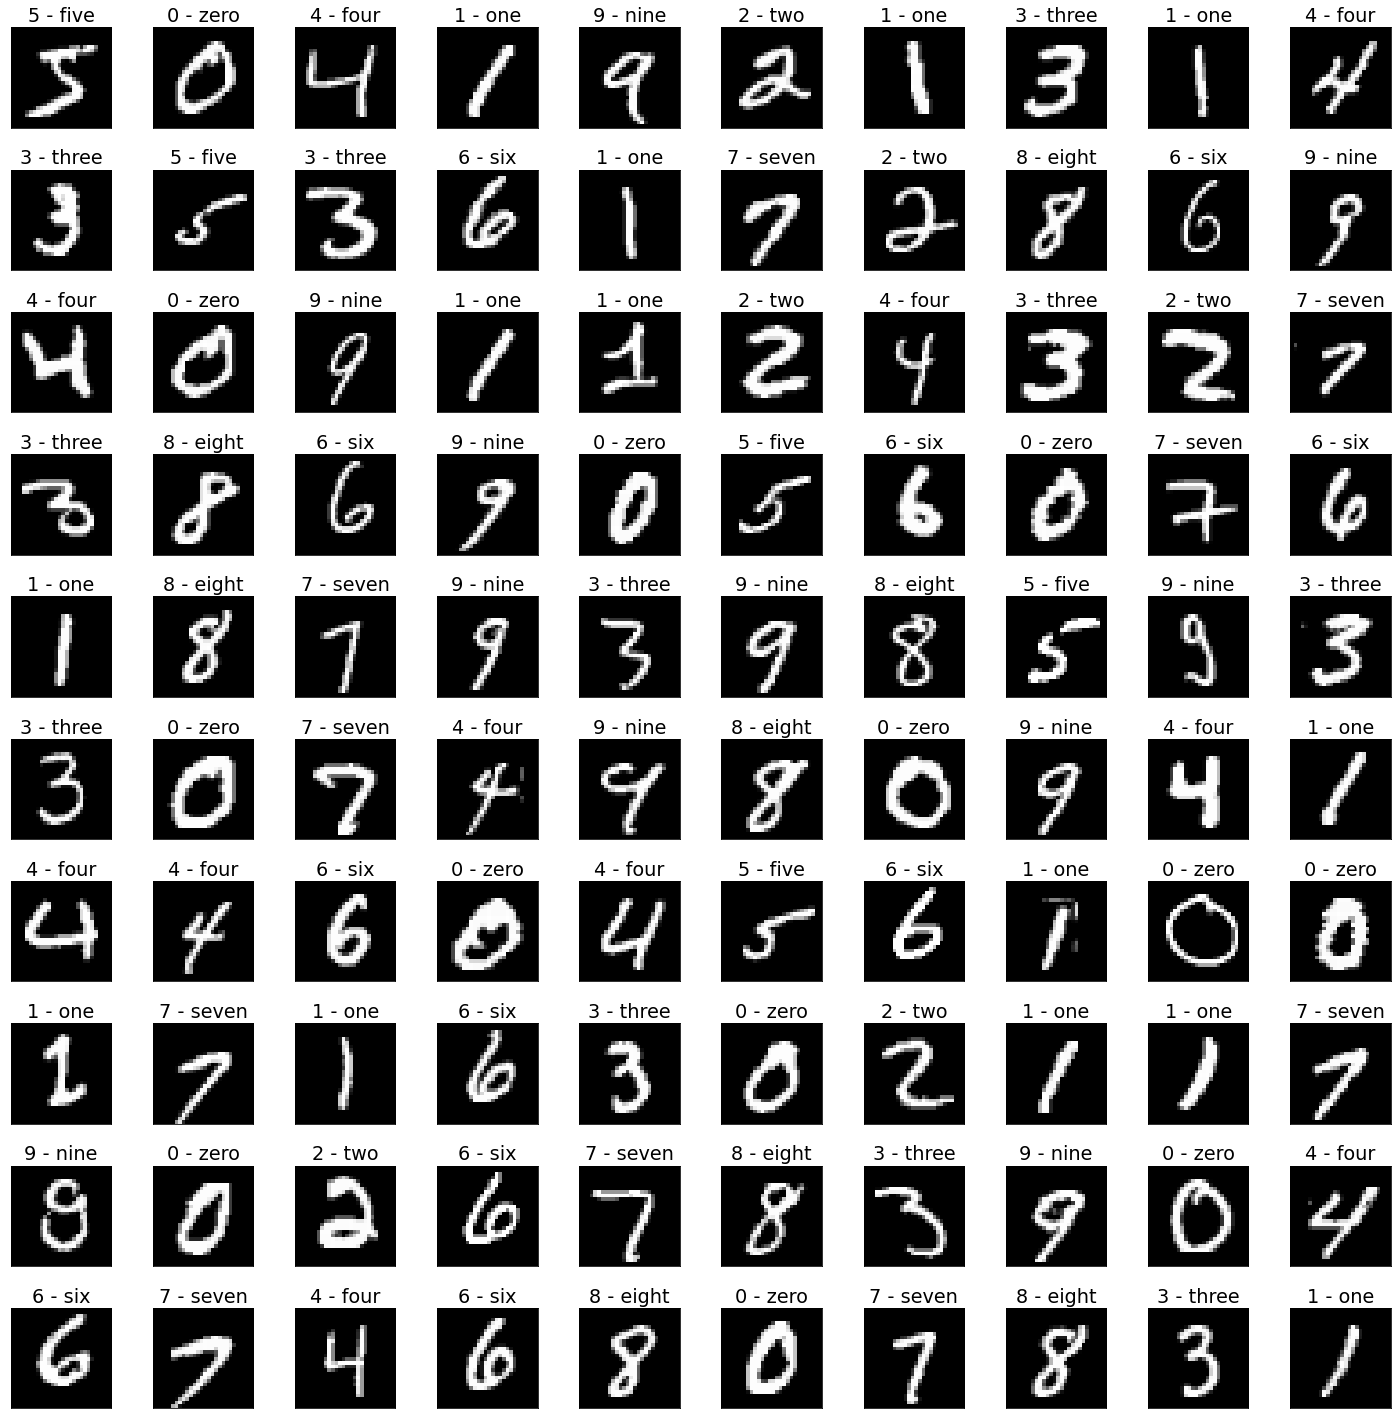

In [10]:
from torchvision.datasets import MNIST

train_dataset = MNIST("./datasets", download=True, train=True)
test_dataset = MNIST("./datasets", download=True, train=False)

fig, axs = plt.subplots(figsize=(20, 20), nrows=10, ncols=10, layout="tight")
for i, ax in enumerate(axs.flatten()):
    image = train_dataset.data[i].numpy()
    label = train_dataset.targets[i].item()
    digit = train_dataset.classes[label]
    show_image(ax, image, title=digit, cmap="gray")

In [11]:
from sklearn.neighbors import KNeighborsClassifier

X_train = train_dataset.data.flatten(start_dim=1).numpy()
Y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.flatten(start_dim=1).numpy()
Y_test = test_dataset.targets.numpy()

classifier = KNeighborsClassifier()
classifier.fit(X_train, Y_train)
accuracy = classifier.score(X_test, Y_test)
print(f"k nearest neighboors accuracy: {accuracy}")

k nearest neighboors accuracy: 0.9688


In [12]:
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader

data = train_dataset.data / 255.
mean = data.mean()
std = data.std()

transform = Compose([
    ToTensor(),
    Normalize((mean,), (std,))
])


train_dataset.transform = transform
test_dataset.transform = transform

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

In [13]:
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score
from tqdm.notebook import trange

device = gpu if torch.cuda.is_available() else cpu
optimizer_type = torch.optim.Adam

def train_one_epoch(model, dataloader, optimizer):
    CSE = CrossEntropyLoss()
    for x, y_true in dataloader:
        # Compute prediction and loss
        x, y_true = x.to(device), y_true.to(device)
        y_pred = model(x)
        loss = CSE(y_pred, y_true)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
def train(model, train_loader, test_loader, n_epochs, writer, lr=0.001):
    optimizer = optimizer_type(model.parameters(), lr=lr)
    model = model.to(device)
    
    # validate
    model.eval()
    train_loss, train_acc = compute_metrics(model, train_loader)
    test_loss, test_acc = compute_metrics(model, test_loader)
    write_logs(writer, train_loss, test_loss, train_acc, test_acc, 0)
        
    # train loop
    for epoch in trange(1, n_epochs + 1):
        # train
        model.train()
        train_one_epoch(model, train_loader, optimizer)
        
        # validate
        model.eval()
        train_loss, train_acc = compute_metrics(model, train_loader)
        test_loss, test_acc = compute_metrics(model, test_loader)
        
        # write to tensorboard logs
        write_logs(writer, train_loss, test_loss, train_acc, test_acc, epoch)
    return test_acc
        
        
def write_logs(writer, train_loss, test_loss, train_acc, test_acc, epoch):
    writer.add_scalars(
            "accuracy", 
            {
                "train": train_acc,
                "test": test_acc
            },
            epoch
        )
    writer.add_scalars(
        "loss", 
        {
            "train": train_loss,
            "test": test_loss
        },
        epoch
    )

        
def compute_metrics(model, dataloader):
    CSE = CrossEntropyLoss(reduction="sum")  
    n = len(dataloader.dataset)
    
    loss = 0.
    correct = 0.
    with torch.no_grad():
        for x, y_true in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss += CSE(y_pred, y_true)
            correct += accuracy_score(y_true.cpu().numpy(), y_pred.argmax(1).cpu().numpy(), normalize=False)
    
    return loss/n, correct/n

In [14]:
import os

from torch.nn import Sequential, Flatten, Linear
from torch.utils.tensorboard import SummaryWriter

h, w = 28, 28
n_pixels = h * w
n_classes = 10
learning_rate = 0.03
n_epochs = 20


linear = Sequential(
    Flatten(),
    Linear(in_features=n_pixels, out_features=n_classes, bias=True)
)

folder = os.path.join("runs", "MNIST", "linear")
train(linear, train_dataloader, test_dataloader, n_epochs, SummaryWriter(folder), learning_rate)

  0%|          | 0/20 [00:00<?, ?it/s]

0.901

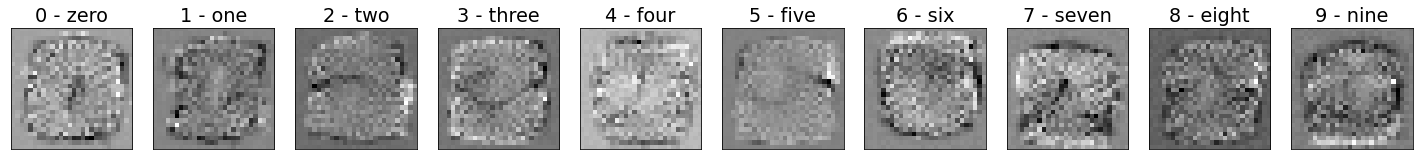

In [15]:
weights = list(linear.parameters())[0].to(cpu).detach().numpy()

fig, axs = plt.subplots(figsize=(20, 20), ncols=10, layout="tight")
for row, ax, title in zip(weights, axs, train_dataset.classes):
    image = row.reshape(h, w)
    show_image(ax, image, title=title, cmap="gray")

In [16]:
from torch.nn import ReLU

two_layers = Sequential(
    Flatten(),
    Linear(in_features=n_pixels, out_features=40, bias=True),
    ReLU(),
    Linear(in_features=40, out_features=n_classes, bias=True)
)

folder = os.path.join("runs", "MNIST", "two_layers")
train(two_layers, train_dataloader, test_dataloader, n_epochs, SummaryWriter(folder), learning_rate)

  0%|          | 0/20 [00:00<?, ?it/s]

0.953

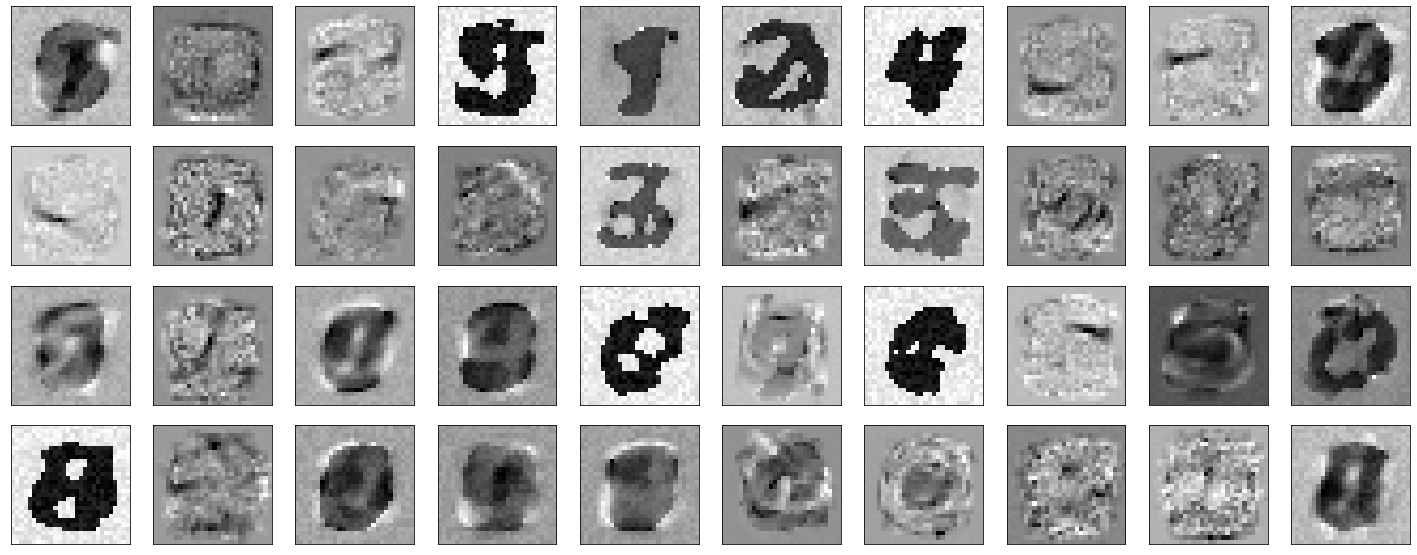

In [17]:
weights = list(two_layers.parameters())[0].to(cpu).detach().numpy()

fig, axs = plt.subplots(figsize=(20, 8), ncols=10, nrows=4, layout="tight")
for row, ax in zip(weights, axs.flatten()):
    image = row.reshape(h, w)
    show_image(ax, image, cmap="gray")

In [18]:
from torch.nn import Conv2d, MaxPool2d

lenet = Sequential(
    Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), padding=2),
    ReLU(),
    MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)),
    ReLU(),
    MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    Flatten(),
    Linear(in_features=400, out_features=120),
    ReLU(),
    Linear(in_features=120, out_features=84),
    ReLU(),
    Linear(in_features=84, out_features=10)
)


folder = os.path.join("runs", "MNIST", "Convolutional")
train(lenet, train_dataloader, test_dataloader, n_epochs, SummaryWriter(folder), lr=0.003)

  0%|          | 0/20 [00:00<?, ?it/s]

0.9876

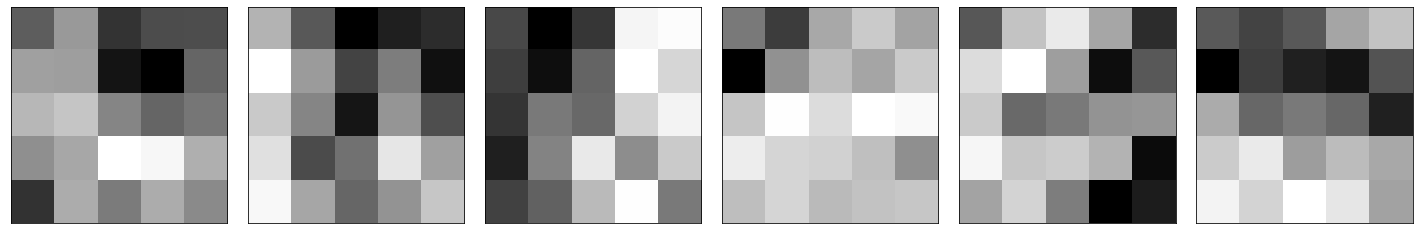

In [19]:
weights = next(lenet.parameters()).to(cpu).detach().numpy()

fig, axs = plt.subplots(figsize=(20, 6), ncols=6, layout="tight")
for row, ax in zip(weights, axs.flatten()):
    image = row.reshape(5, 5)
    show_image(ax, image, cmap="gray")

## CIFAR10

Files already downloaded and verified
Files already downloaded and verified


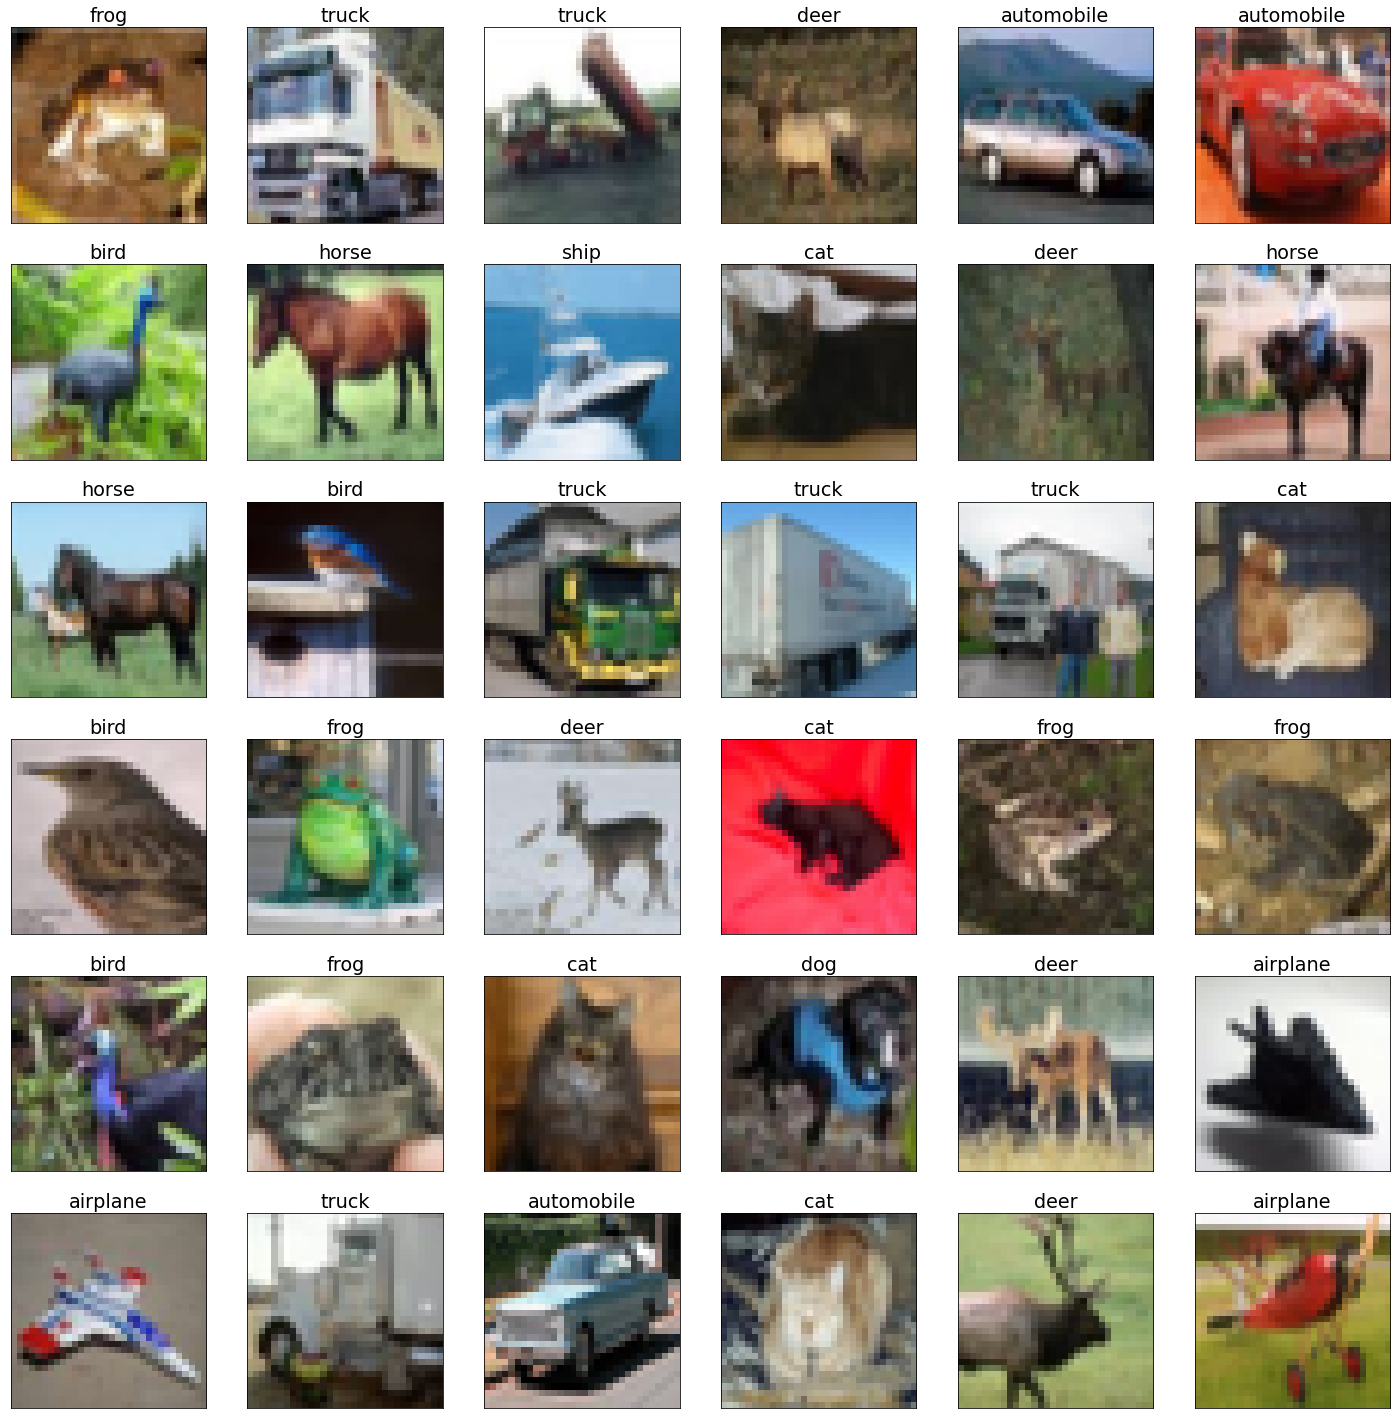

In [20]:
from torchvision.datasets import CIFAR10

train_dataset = CIFAR10("./datasets", download=True, train=True)
test_dataset = CIFAR10("./datasets", download=True, train=False)

fig, axs = plt.subplots(figsize=(20, 20), nrows=6, ncols=6, layout="tight")
for i, ax in enumerate(axs.flatten()):
    image = train_dataset.data[i]
    label = train_dataset.targets[i]
    digit = train_dataset.classes[label]
    show_image(ax, image, title=digit)

In [21]:
h, w, c = 32, 32, 3
n_pixels = h * w * c
n_classes = 10
n_epochs = 20

X_train = train_dataset.data.reshape(-1, n_pixels)
Y_train = train_dataset.targets
X_test = test_dataset.data.reshape(-1, n_pixels)
Y_test = test_dataset.targets

classifier = KNeighborsClassifier()
classifier.fit(X_train, Y_train)
accuracy = classifier.score(X_test, Y_test)
print(f"k nearest neighboors accuracy: {accuracy}")

k nearest neighboors accuracy: 0.3398


In [22]:
data = train_dataset.data / 255.
mean = data.mean(axis=(0, 1, 2))
std = data.std(axis=(0, 1, 2))

transform = Compose([
    ToTensor(),
    Normalize(tuple(mean), tuple(std))
])


train_dataset = CIFAR10("./datasets", download=True, train=True, transform=transform)
test_dataset = CIFAR10("./datasets", download=True, train=False, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
optimizer_type = torch.optim.SGD

linear = Sequential(
    Flatten(),
    Linear(in_features=n_pixels, out_features=n_classes)
)

learning_rate = 0.1
folder = os.path.join("runs", "CIFAR10", "linear")
accuracy = train(linear, train_dataloader, test_dataloader, n_epochs, SummaryWriter(folder), learning_rate)
print(f"accuracy of logistic regression: {accuracy}")

  0%|          | 0/20 [00:00<?, ?it/s]

accuracy of logistic regression: 0.2574


In [24]:
three_layers = Sequential(
    Flatten(),
    Linear(in_features=n_pixels, out_features=120),
    ReLU(),
    Linear(in_features=120, out_features=86),
    ReLU(),
    Linear(in_features=86, out_features=n_classes)
)

folder = os.path.join("runs", "CIFAR10", "three_layers")
accuracy = train(three_layers, train_dataloader, test_dataloader, n_epochs, SummaryWriter(folder), learning_rate)
print(f"accuracy of three layered model: {accuracy}")

  0%|          | 0/20 [00:00<?, ?it/s]

accuracy of three layered model: 0.5028


In [25]:
from torch.nn import Conv2d, MaxPool2d

lenet = Sequential(
    Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5)),
    ReLU(),
    MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)),
    ReLU(),
    MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    Flatten(),
    Linear(in_features=400, out_features=120),
    ReLU(),
    Linear(in_features=120, out_features=84),
    ReLU(),
    Linear(in_features=84, out_features=10)
)


folder = os.path.join("runs", "CIFAR10", "Convolutional")
accuracy = train(lenet, train_dataloader, test_dataloader, n_epochs, SummaryWriter(folder), lr=0.1)
print(f"accuracy of convolutional model: {accuracy}")

  0%|          | 0/20 [00:00<?, ?it/s]

accuracy of convolutional model: 0.5697


In [26]:
def compute_number_of_paramets(model):
    return sum(parameters.cpu().detach().numpy().size   for parameters in model.parameters())

models = {
    "linear": linear,
    "three layers": three_layers,
    "convolutional": lenet
}

for model_name, model in models.items():
    n = compute_number_of_paramets(model)
    print(f"{model_name}: {n}")

linear: 30730
three layers: 380036
convolutional: 62006
